<a href="https://colab.research.google.com/github/Wojtek130/Neural-Networks/blob/main/Sweep_WandB_CNN_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
# W&B install and login
!pip install wandb
import wandb
wandb.login()

True

In [ ]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

Using downloaded and verified file: ./cifar10.tgz


In [ ]:
# dataset demo
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

['test', 'train']
['cat', 'frog', 'airplane', 'horse', 'deer', 'ship', 'truck', 'automobile', 'dog', 'bird']
No. of training examples for airplanes: 5000
['3686.png', '3168.png', '0274.png', '1848.png', '2403.png']


In [ ]:
# creating datasets from folders
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
# show image tensor
img, label = dataset[0]
# print(img.shape, label)
# img

Label:  airplane (0)


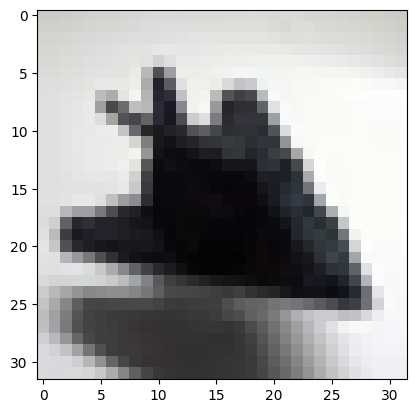

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[0])

In [ ]:
# 1. splitting the dataset
random_seed = 42
torch.manual_seed(random_seed)
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
dataset[0][0].shape, "!!!!"

(torch.Size([3, 32, 32]), '!!!!')

In [ ]:
# W&B Config
# config = dict(
#     epochs=5,
#     classes=10,
#     # kernels=[16, 32],
#     batch_size=128,
#     learning_rate=0.005,
#     dataset="CIFAR",
#     architecture="CNN")

sweep_config = {
    'method': 'random',  # random, grid or bayes
    'name': 'sweep-cifar',
    'metric': {'goal': 'minimize', 'name': 'val_loss'},
    'parameters':
    {
        'batch_size': {'values': [64, 128, 256]},
        'epochs': {'values': [5, 10, 15]},
        'learning_rate': {'values': [0.1, 0.01, 0.001]},
        # 'learning_rate': {'max': 0.1, 'min': 0.0001},
            'optimizer': {
        'values': ['adam', 'sgd']
        },
     },

}

sweep_id = wandb.sweep(sweep_config, project="cifar-swp")

# wandb.init(
#     # set the wandb project where this run will be logged
#     project="cifar-swp",

#     # track hyperparameters and run metadata
#     # config={
#     # "learning_rate": 0.02,
#     # "architecture": "CNN",
#     # "dataset": "CIFAR-100",
#     # "epochs": 10,
#     # }
#     config = config
# )

Create sweep with ID: wdh892sn
Sweep URL: https://wandb.ai/wsniady-org/cifar-swp/sweeps/wdh892sn


In [ ]:
# 2. creating the dataloaders


In [ ]:
# 3a. GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# 4. Model definition

def create_model():
    model = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=3, stride = 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # output: bs x 16 x 16 x 16

        nn.Conv2d(16, 16, kernel_size=3, stride = 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # output: bs x 16 x 8 x 8

        nn.Conv2d(16, 16, kernel_size=3, stride = 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # output: bs x 16 x 4 x 4

        nn.Conv2d(16, 16, kernel_size=3, stride = 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # output: bs x 16 x 2 x 2

        nn.Conv2d(16, 16, kernel_size=3, stride = 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # output: bs x 16 x 1 x 1

        nn.Flatten(), # output: bs x 16
        nn.Linear(16, 10)
    )
    return model

In [ ]:
# 5. Loss batch
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_func(preds, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    return loss.item(), len(xb), metric_result

In [ ]:
# 6. Accuracy (metric)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# 7. Training function
def fit(epochs, model, loss_fn, train_dl, valid_dl, opt_func=torch.optim.SGD, lr=None, metric=None):
    train_losses, val_losses, val_metrics = [], [], []
    opt = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

        # evalutation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        # record the loss and metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)

        train_loss_f = float(train_loss)
        val_loss_f = float(val_loss)
        val_metric_f = float(val_metric)
        if metric is None:
            print(f"Epoch [{epoch+1}/{epochs}], train loss: {train_loss}, val_loss {val_loss}")
            wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss" : val_loss.item()})

        else:
            print(f"Epoch [{epoch+1}/{epochs}], train loss: {train_loss}, val_loss {val_loss}, val_{metric.__name__}: {val_metric}")
            wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss" : val_loss.item(), "val_accuracy" : val_metric.item()})



    return train_losses, val_losses, val_metrics

In [ ]:
# 8. Model evaluation
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        #separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # total size of the dataset
        total = np.sum(nums)
        # avg. loss acreoss batches
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [ ]:
# 3b. Moving data to GPU




In [ ]:
# one iteration
# val_loss, _, val_acc = evaluate(model, F.cross_entropy, valid_dl, metric = accuracy)

In [ ]:
# num_epochs = 10
# opt_fn = torch.optim.Adam
# lr = 0.005

In [ ]:
def create_optimizer(model, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD
    elif optimizer == "adam":
        optimizer = torch.optim.Adam
    return optimizer

In [ ]:
def main(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        batch_size= wandb.config.batch_size
        train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
        valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
        test_dl = DataLoader(test_dataset, batch_size*2)
        model = create_model()

        device = get_default_device()
        train_dl = DeviceDataLoader(train_dl, device)
        valid_dl = DeviceDataLoader(valid_dl, device)
        test_dl = DeviceDataLoader(test_dl, device)
        to_device(model, device)

        opt_fn = create_optimizer(model, wandb.config.optimizer, wandb.config.learning_rate)

        history = fit(wandb.config.epochs, model, F.cross_entropy, train_dl, valid_dl, opt_fn, wandb.config.learning_rate, accuracy)

In [ ]:
wandb.agent(sweep_id, main, count=5)

wandb: Agent Starting Run: ti7ndk2o with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Epoch [1/5], train loss: 2.2984209060668945, val_loss 2.306360334777832, val_accuracy: 0.09720000004768371
Epoch [2/5], train loss: 2.122063159942627, val_loss 2.140696783065796, val_accuracy: 0.23199999976158142
Epoch [3/5], train loss: 1.9453669786453247, val_loss 1.927456054878235, val_accuracy: 0.2955999997138977
Epoch [4/5], train loss: 1.881460428237915, val_loss 1.8867064418792725, val_accuracy: 0.2921999999046326
Epoch [5/5], train loss: 1.6937716007232666, val_loss 1.67265100440979, val_accuracy: 0.3956000000476837


epoch,▁▃▅▆█
train_loss,█▆▄▃▁
val_accuracy,▁▄▆▆█
val_loss,█▆▄▃▁
epoch,5
train_loss,1.69377
val_accuracy,0.3956
val_loss,1.67265


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x1va64ou with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch [1/5], train loss: 2.320955753326416, val_loss 2.3149747982025146, val_accuracy: 0.09539999988079072
Epoch [2/5], train loss: 2.296536445617676, val_loss 2.3143547660827637, val_accuracy: 0.09539999988079072
Epoch [3/5], train loss: 2.3308305740356445, val_loss 2.3137641498565675, val_accuracy: 0.09539999988079072
Epoch [4/5], train loss: 2.322023391723633, val_loss 2.313202778625488, val_accuracy: 0.09539999988079072
Epoch [5/5], train loss: 2.3297269344329834, val_loss 2.3126686473846436, val_accuracy: 0.09539999988079072


epoch,▁▃▅▆█
train_loss,▆▁█▆█
val_accuracy,▁▁▁▁▁
val_loss,█▆▄▃▁
epoch,5
train_loss,2.32973
val_accuracy,0.0954
val_loss,2.31267


wandb: Agent Starting Run: yb2si9mt with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Epoch [1/10], train loss: 2.2992255687713623, val_loss 2.3026005725860594, val_accuracy: 0.10140000003576279
Epoch [2/10], train loss: 2.3015549182891846, val_loss 2.3021366497039795, val_accuracy: 0.09880000005960464
Epoch [3/10], train loss: 2.2933168411254883, val_loss 2.2850416500091555, val_accuracy: 0.141800000166893
Epoch [4/10], train loss: 2.039890766143799, val_loss 2.082632991027832, val_accuracy: 0.22439999980926514
Epoch [5/10], train loss: 1.8670883178710938, val_loss 2.1039266078948975, val_accuracy: 0.21899999995231628
Epoch [6/10], train loss: 1.8034014701843262, val_loss 1.9094898012161254, val_accuracy: 0.2769999999523163
Epoch [7/10], train loss: 1.491351842880249, val_loss 1.7095907766342162, val_accuracy: 0.3658000002384186
Epoch [8/10], train loss: 1.7260061502456665, val_loss 1.6979497245788575, val_accuracy: 0.39219999976158143
Epoch [9/10], train loss: 1.497849702835083, val_loss 1.5588113805770873, val_accuracy: 0.4241999997615814
Epoch [10/10], train loss: 1

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,███▆▅▄▂▄▂▁
val_accuracy,▁▁▂▄▄▅▇▇██
val_loss,███▆▆▄▂▂▁▁
epoch,10
train_loss,1.33416
val_accuracy,0.4282
val_loss,1.60891


wandb: Agent Starting Run: jwrq7re2 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam


Epoch [1/10], train loss: 2.307204246520996, val_loss 2.30370259513855, val_accuracy: 0.09720000016689301
Epoch [2/10], train loss: 2.3175759315490723, val_loss 2.307032345581055, val_accuracy: 0.09999999998807907
Epoch [3/10], train loss: 2.302896022796631, val_loss 2.3041247787475587, val_accuracy: 0.0960000000834465
Epoch [4/10], train loss: 2.3074285984039307, val_loss 2.305101602935791, val_accuracy: 0.0987999998807907
Epoch [5/10], train loss: 2.3092970848083496, val_loss 2.3067911087036133, val_accuracy: 0.09999999998807907
Epoch [6/10], train loss: 2.310331344604492, val_loss 2.306003419494629, val_accuracy: 0.10839999980926514
Epoch [7/10], train loss: 2.3059005737304688, val_loss 2.304223194503784, val_accuracy: 0.0987999998807907
Epoch [8/10], train loss: 2.3186194896698, val_loss 2.308837943267822, val_accuracy: 0.0987999998807907
Epoch [9/10], train loss: 2.3250582218170166, val_loss 2.306198554611206, val_accuracy: 0.09980000026226044
Epoch [10/10], train loss: 2.30335378

epoch,▁▂▃▃▄▅▆▆▇█
train_loss,▂▆▁▂▃▃▂▆█▁
val_accuracy,▂▃▁▃▃█▃▃▃▃
val_loss,▁▆▂▃▅▄▂█▄▄
epoch,10
train_loss,2.30335
val_accuracy,0.0988
val_loss,2.30615


wandb: Agent Starting Run: 7oko0cbq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


Epoch [1/15], train loss: 1.628826379776001, val_loss 1.610162833213806, val_accuracy: 0.3872
Epoch [2/15], train loss: 1.9235855340957642, val_loss 1.6879870380401611, val_accuracy: 0.3872
Epoch [3/15], train loss: 1.4098727703094482, val_loss 1.603538564491272, val_accuracy: 0.4092
Epoch [4/15], train loss: 1.6144227981567383, val_loss 1.5369551643371582, val_accuracy: 0.4398
Epoch [5/15], train loss: 1.176954984664917, val_loss 1.5420450239181518, val_accuracy: 0.4352
Epoch [6/15], train loss: 1.7680782079696655, val_loss 1.4731931001663208, val_accuracy: 0.4538
Epoch [7/15], train loss: 1.5214707851409912, val_loss 1.4314484407424928, val_accuracy: 0.4772
Epoch [8/15], train loss: 1.343281626701355, val_loss 1.4345615379333496, val_accuracy: 0.4702
Epoch [9/15], train loss: 1.9740784168243408, val_loss 1.453359434890747, val_accuracy: 0.4644
Epoch [10/15], train loss: 1.2467175722122192, val_loss 1.5247537103652955, val_accuracy: 0.4386
Epoch [11/15], train loss: 1.9580912590026855

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,▄▆▃▄▁▅▃▂▆▂▆█▅▅▁
val_accuracy,▁▁▃▅▄▆▇▇▆▅▇▆▇▅█
val_loss,▆█▆▄▄▂▁▁▂▄▂▃▁▅▁
epoch,15
train_loss,1.11428
val_accuracy,0.4884
val_loss,1.41844


In [ ]:
# test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)
# test_loss, _, test_acc = evaluate(model, F.cross_entropy, test_dl, metric  = accuracy)
# test_loss, test_acc

In [ ]:
wandb.finish()